# <span style="color:red">**PRAICP-1012 - Pneumonia Chest X-ray Classification**</span>


#### *Team ID: PTID-AI-APR-25-1112*

## **Pneumonia**

Pneumonia is a lung infection that causes inflammation in the air sacs (alveoli) of one or both lungs.

**Symptoms:**
The air sacs may fill with fluid or pus, leading to cough with phlegm or pus, fever, chills, and difficulty breathing.

**Causes:**
It can be caused by various microorganisms, including bacteria, viruses, and fungi.

**Severity:**
Pneumonia can range from mild to life-threatening, depending on the person’s health condition and the cause.

**High-Risk Groups:**
It is most dangerous for infants, young children, elderly people (65+), and those with chronic illnesses or weakened immune systems.

## **Business Case**

**Objective:**

To develop a machine learning model that can automatically classify chest X-ray images to detect the presence of Pneumonia.



## Importing Libraries

In [ ]:
# =========================
# General Purpose Libraries
# =========================
import os
import random
import warnings
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Ignore Warnings
warnings.filterwarnings('ignore')

# =========================
# Scikit-learn Libraries
# =========================
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# =========================
# TensorFlow & Keras Core
# =========================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Conv2D, MaxPooling2D, MaxPool2D, Dropout, Flatten, BatchNormalization,
    GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2

# =========================
# Data Augmentation
# =========================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# =========================
# Pretrained CNN Architectures
# =========================
from tensorflow.keras.applications import (
    MobileNetV2, DenseNet121, ResNet50V2
)


## Loading the Dataset

In [ ]:
# Defining dataset path
data_dir = "/content/drive/MyDrive/data/chest_xray"

In [ ]:
files=os.listdir(data_dir)
print(files)

['val', 'train', 'test']


In [ ]:
train_dir=os.path.join(data_dir,'train')
test_dir=os.path.join(data_dir,'test')
val_dir=os.path.join(data_dir,'val')

In [ ]:
train_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
train_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
test_normal = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
test_pneumonia = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
val_normal = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
val_pneumonia = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))

print(f"Train - Normal: {train_normal}, Pneumonia: {train_pneumonia}")
print(f"Test - Normal: {test_normal}, Pneumonia: {test_pneumonia}")
print(f"Validation - Normal: {val_normal}, Pneumonia: {val_pneumonia}")


Train - Normal: 1342, Pneumonia: 3876
Test - Normal: 234, Pneumonia: 390
Validation - Normal: 9, Pneumonia: 9


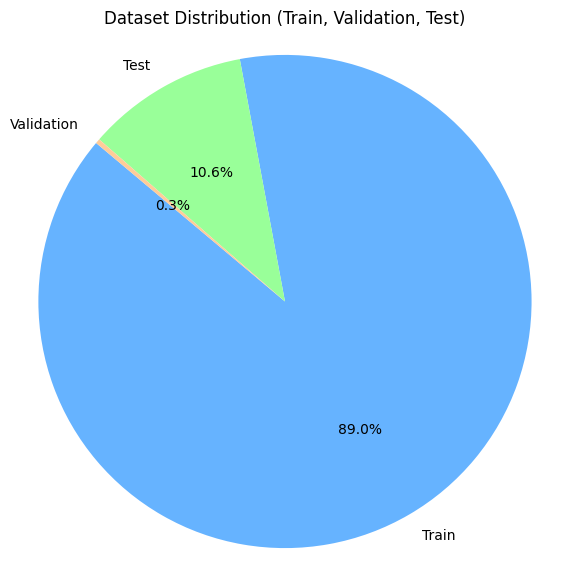

In [ ]:
# Counts for each dataset category (Normal and Pneumonia)
train_normal = 1342
train_pneumonia = 3876
test_normal = 234
test_pneumonia = 390
val_normal = 9
val_pneumonia = 9
train_total = train_normal + train_pneumonia
test_total = test_normal + test_pneumonia
val_total = val_normal + val_pneumonia


labels = ['Train', 'Test', 'Validation']
sizes = [train_total, test_total, val_total]
colors = ['#66b3ff', '#99ff99', '#ffcc99']


plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Dataset Distribution (Train, Validation, Test)')
plt.axis('equal')
plt.show()


In [ ]:
# Total counts
total_train = train_normal + train_pneumonia
total_test = test_normal + test_pneumonia
total_val = val_normal + val_pneumonia
total_all = total_train + total_test + total_val
print(f"Overall Total Images: {total_all}")

Overall Total Images: 5860


## Comparison of Chest X-rays: Normal vs Pneumonia

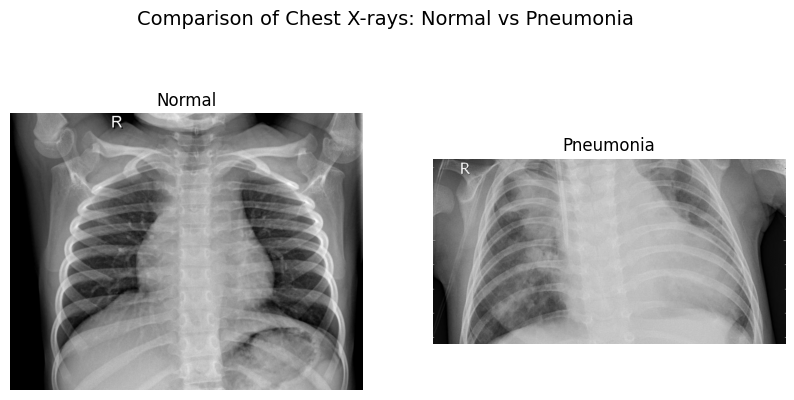

In [ ]:
normal_img_path = os.path.join(train_dir, 'NORMAL', os.listdir(os.path.join(train_dir, 'NORMAL'))[1])
pneumonia_img_path = os.path.join(train_dir, 'PNEUMONIA', os.listdir(os.path.join(train_dir, 'PNEUMONIA'))[50])

# Load images in grayscale
normal_img = cv.imread(normal_img_path, cv.IMREAD_GRAYSCALE)
pneumonia_img = cv.imread(pneumonia_img_path, cv.IMREAD_GRAYSCALE)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(normal_img, cmap='gray')
plt.title("Normal")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pneumonia_img, cmap='gray')
plt.title("Pneumonia")
plt.axis('off')

plt.suptitle("Comparison of Chest X-rays: Normal vs Pneumonia", fontsize=14)
plt.show()

## Basic check on Images

In [ ]:
classes = ["NORMAL", "PNEUMONIA"]

for cls in classes:
    class_path = os.path.join(train_dir, cls)
    image_files = os.listdir(class_path)

    if not image_files:
        print(f"No images found in {cls} folder.")
        continue


    image_path = os.path.join(class_path, image_files[0])
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)  # Load as grayscale

    if image is None:
        print(f"Failed to load image: {image_path}")
        continue

    height, width = image.shape

    # Compute statistics
    min_val = np.min(image)
    max_val = np.max(image)
    mean_val = np.mean(image)
    std_val = np.std(image)

    print(f"\n--- {cls} Class ---")
    print(f"Image: {image_files[0]}")
    print(f"Image Dimensions: {width} pixels (width) × {height} pixels (height)")
    print(f"Color Channels: 1 (Grayscale)")
    print(f"Minimum Pixel Value: {min_val:.4f}")
    print(f"Maximum Pixel Value: {max_val:.4f}")
    print(f"Mean Pixel Value: {mean_val:.4f}")
    print(f"Standard Deviation: {std_val:.4f}")



--- NORMAL Class ---
Image: NORMAL2-IM-1026-0001.jpeg
Image Dimensions: 1836 pixels (width) × 1604 pixels (height)
Color Channels: 1 (Grayscale)
Minimum Pixel Value: 0.0000
Maximum Pixel Value: 255.0000
Mean Pixel Value: 122.8329
Standard Deviation: 65.7127

--- PNEUMONIA Class ---
Image: person1936_bacteria_4852.jpeg
Image Dimensions: 1064 pixels (width) × 552 pixels (height)
Color Channels: 1 (Grayscale)
Minimum Pixel Value: 0.0000
Maximum Pixel Value: 255.0000
Mean Pixel Value: 114.7650
Standard Deviation: 54.1988


### ***Insights***
➡️Resolution Difference :The NORMAL class image is larger (1554 × 1402 pixels) compared to the PNEUMONIA class image (1010 × 562 pixels), means that the images may vary in size and detail.

➡️Brightness: The PNEUMONIA image is a bit brighter on average.( mean pixel value (134.42 vs. 120.39).)

➡️Intensity: The PNEUMONIA image has slightly lower brightness levels (less intense).(max pixel value (219 vs. 255).)


➡️Variation: The NORMAL image has more differences in brightness (more contrast), while PNEUMONIA looks smoother.

## Distribution of Dataset

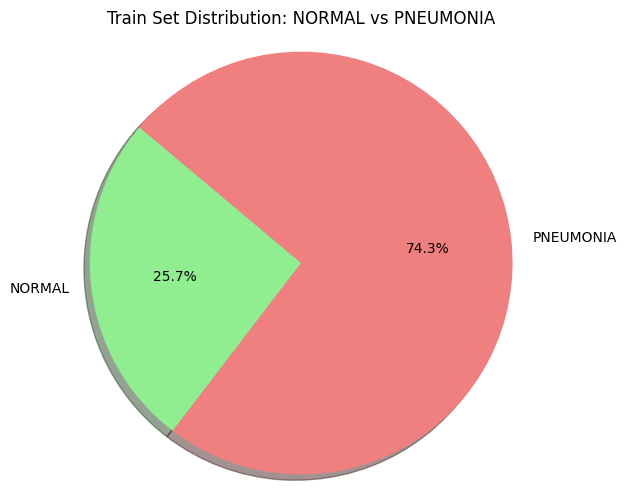

In [ ]:
labels = ['NORMAL', 'PNEUMONIA']
sizes = [train_normal, train_pneumonia]
colors = ['lightgreen', 'lightcoral']


plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title("Train Set Distribution: NORMAL vs PNEUMONIA")
plt.axis('equal')
plt.show()


### ***Insights***
➡️The train set has a class imbalance, with **74.3%** of the images labeled as Pneumonia and **25.7%** as Normal.

➡️This imbalance may cause the model to be biased towards predicting Pneumonia so balancing is required











In [ ]:
train_datagen = ImageDataGenerator(
     rescale=1./255,
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

# Load data using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),  # Resize all images to 224x224
    batch_size=64,
    class_mode='binary',
    shuffle=True,
)


test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False,

)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False

)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


 ## ***class weights***
➡️class weights helps the model handle imbalanced datasets better.

➡️The model "pays more attention" to the minority class (Normal) during training.

➡️Loss from the underrepresented class is weighted more heavily, so the model is penalized more when it misclassifies it.

➡️This balances the learning, preventing the model from becoming biased toward the majority class (Pneumonia this your case).

In [ ]:
# Number of training images in each class
num_normal = 1342
num_pneumonia = 3876

# calculating class weights
weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0 (Normal): {weight_for_0:.2f}")
print(f"Weight for class 1 (Pneumonia): {weight_for_1:.2f}")



Weight for class 0 (Normal): 0.74
Weight for class 1 (Pneumonia): 0.26


Normal class (0) is underrepresented (25% of the data).

Pneumonia class (1) is overrepresented (75% of the data).

Weight for Normal Class: we assign a higher weight (larger penalty) to misclassifying Normal samples.

Weight for Pneumonia Class: we assign a lower weight to misclassifying Pneumonia samples, since they are overrepresented in the data.

## Typical CNN Model

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(224, 224,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 220, 220, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 106, 106, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 49, 49, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    18,874,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,311,521 (73.67 MB)

 Trainable params: 19,310,369 (73.66 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    batch_size=64,
    class_weight=class_weight,
    verbose=1
)

model.save("chest_xray_custom_cnn_model.h5")
model_cnn= load_model("chest_xray_custom_cnn_model.h5")


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1034s 13s/step - accuracy: 0.7824 - loss: 0.1433 - val_accuracy: 0.5000 - val_loss: 23.8022
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 75s 914ms/step - accuracy: 0.8716 - loss: 0.0833 - val_accuracy: 0.5000 - val_loss: 36.2253
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 73s 892ms/step - accuracy: 0.9272 - loss: 0.0719 - val_accuracy: 0.5000 - val_loss: 63.9899
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 77s 937ms/step - accuracy: 0.9330 - loss: 0.0726 - val_accuracy: 0.5000 - val_loss: 39.7842
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 80s 909ms/step - accuracy: 0.9359 - loss: 0.0527 - val_accuracy: 0.5000 - val_loss: 45.2900
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 75s 908ms/step - accuracy: 0.9483 - loss: 0.0493 - val_accuracy: 0.7500 - val_loss: 2.6472
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 74s 904ms/step - accuracy: 0.9505 - loss: 0.0362 - val_accuracy: 0.5000 - val_loss: 12.8990
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 76s 926ms/step - accuracy: 0.9495 - loss: 0.0349 - va

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.8338 - loss: 0.7953


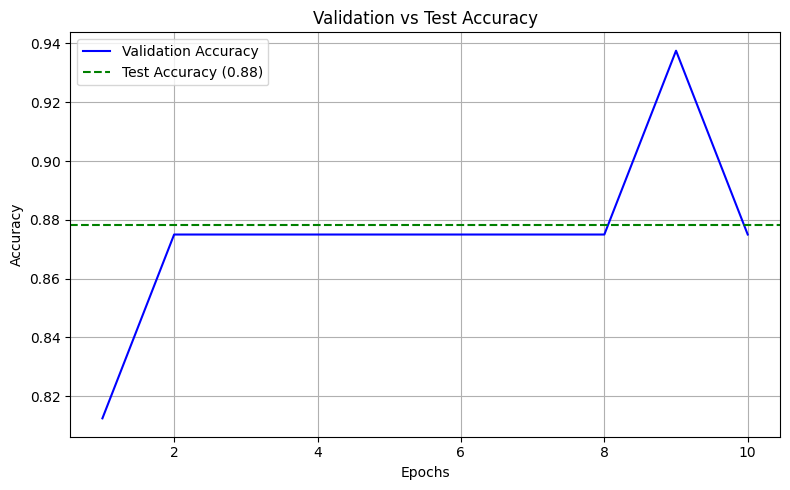

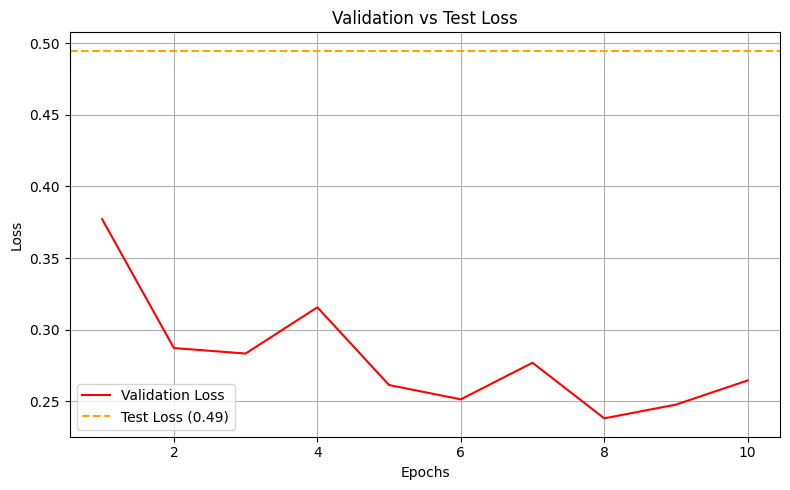

In [ ]:
test_loss, test_accuracy = model_cnn.evaluate(test_generator, verbose=1)

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1, len(val_accuracy) + 1)

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, val_accuracy, 'b-', label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='green', linestyle='--', label=f'Test Accuracy ({test_accuracy:.2f})')
plt.title('Validation vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.axhline(y=test_loss, color='orange', linestyle='--', label=f'Test Loss ({test_loss:.2f})')
plt.title('Validation vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 443s 23s/step
Accuracy: 0.8782
F1 Score: 0.9075


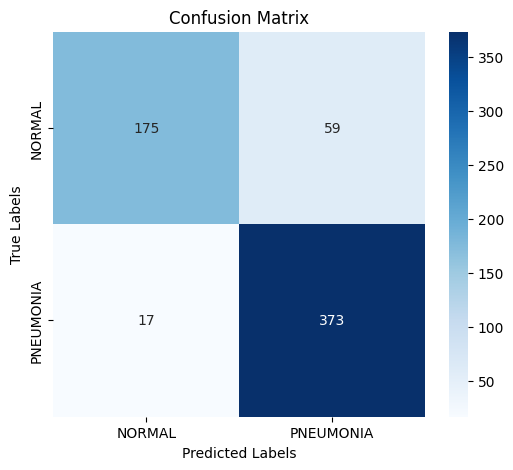


Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.91      0.75      0.82       234
   PNEUMONIA       0.86      0.96      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.85      0.86       624
weighted avg       0.88      0.88      0.88       624



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
pred_probs = model_cnn.predict(test_generator)
y_pred = (pred_probs > 0.5).astype(int).flatten()
y_true = test_generator.classes
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
# Accuracy and F1 Score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

## Transfer Learning
**Transfer Learning** is a deep learning technique where a pre-trained model (trained on a large dataset like ImageNet) is adapted to a new but related task.

Instead of training from scratch, we reuse learned features, fine-tune some layers, and train only the classifier, saving time and improving accuracy, especially for small datasets

## DenseNet 121

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False
model_dense121 = Sequential([
    base_model,
    GlobalAveragePooling2D(),

    BatchNormalization(),
    Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.4),

    BatchNormalization(),
    Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(64, activation="relu"),
    Dropout(0.2),

    Dense(32, activation="relu"),

    Dense(1, activation="sigmoid")
])

# Optimizer
optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

model_dense121.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

model_dense121.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,348,289 (28.03 MB)

 Trainable params: 6,457,409 (24.63 MB)

 Non-trainable params: 890,880 (3.40 MB)

In [ ]:
history = model_dense121.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weight,
    verbose=1
)

model_dense121.save("chest_xray_dense121.h5")
model_dense= load_model("chest_xray_dense121.h5")


Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.6797 - loss: 0.8318 - precision: 0.8123 - recall: 0.7456 - val_accuracy: 0.7500 - val_loss: 1.2007 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 76s 922ms/step - accuracy: 0.8592 - loss: 0.7105 - precision: 0.9715 - recall: 0.8332 - val_accuracy: 0.8125 - val_loss: 1.0146 - val_precision: 0.7778 - val_recall: 0.8750
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 77s 928ms/step - accuracy: 0.9194 - loss: 0.6646 - precision: 0.9855 - recall: 0.9057 - val_accuracy: 0.9375 - val_loss: 0.9140 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 76s 925ms/step - accuracy: 0.9417 - loss: 0.6433 - precision: 0.9853 - recall: 0.9352 - val_accuracy: 0.9375 - val_loss: 0.8213 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 76s 920ms/step - accuracy: 0.9611 - loss: 0.6220 - precision: 0.9903 - recall: 0.9568 - val_accuracy: 0.9375 - val_loss:

20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 637ms/step - accuracy: 0.7133 - loss: 1.6526 - precision: 0.4160 - recall: 0.6667
Evaluation Results: [1.2043489217758179, 0.8349359035491943, 0.7910750508308411, 1.0]
Metrics Names: ['loss', 'compile_metrics']


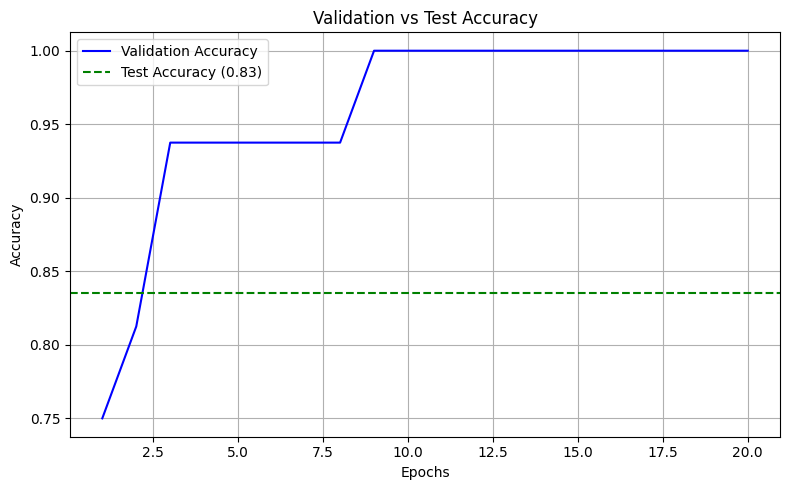

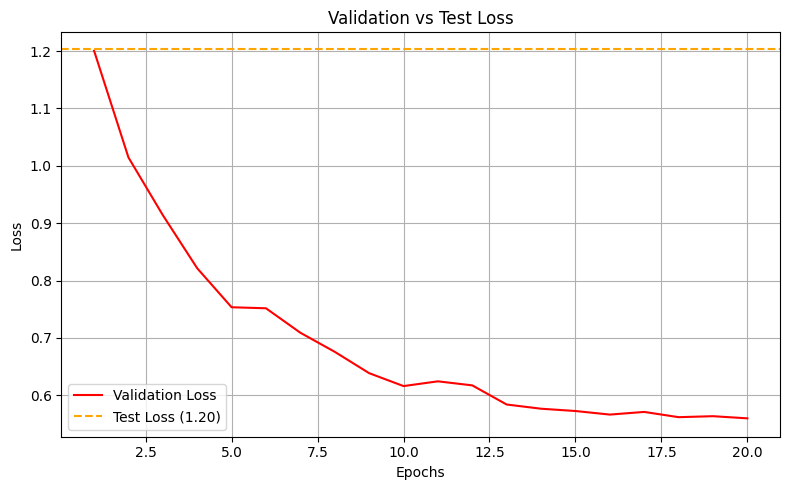

In [ ]:
results = model_dense.evaluate(test_generator, verbose=1)
print("Evaluation Results:", results)
print("Metrics Names:", model_cnn.metrics_names)

test_loss = results[0]
test_accuracy = results[1]
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1, len(val_accuracy) + 1)

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, val_accuracy, 'b-', label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='green', linestyle='--', label=f'Test Accuracy ({test_accuracy:.2f})')
plt.title('Validation vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.axhline(y=test_loss, color='orange', linestyle='--', label=f'Test Loss ({test_loss:.2f})')
plt.title('Validation vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 865ms/step
Accuracy: 0.8349
F1 Score: 0.8834


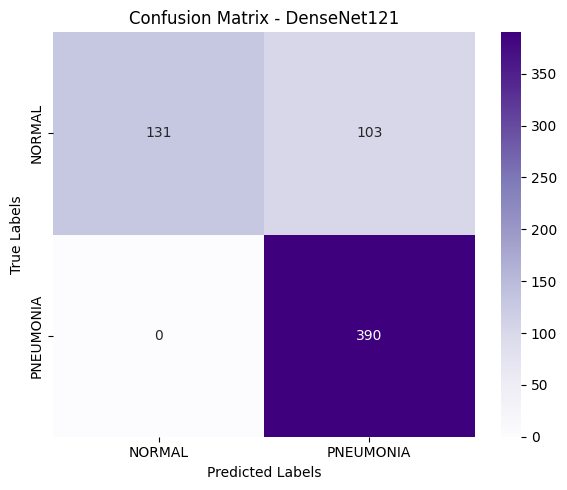


📊 Classification Report:

              precision    recall  f1-score   support

      NORMAL       1.00      0.56      0.72       234
   PNEUMONIA       0.79      1.00      0.88       390

    accuracy                           0.83       624
   macro avg       0.90      0.78      0.80       624
weighted avg       0.87      0.83      0.82       624



In [ ]:
pred_probs = model_dense.predict(test_generator)
y_pred = (pred_probs > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Accuracy and F1-score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix - DenseNet121")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

# Classification Report
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

## MobileNet V2

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model_mobilenetv2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    #Prevents overfitting by penalizing large weights
    Dropout(0.4),
    Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model_mobilenetv2.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)
model_mobilenetv2.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,629,697 (10.03 MB)

 Trainable params: 371,713 (1.42 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model_mobilenetv2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weight,
    verbose=1
)

model_mobilenetv2.save("chest_xray_mobile_net.h5")
model_mobile = load_model("chest_xray_mobile_net.h5")

Epoch 1/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 94s 982ms/step - accuracy: 0.6237 - loss: 5.8777 - precision: 0.8304 - recall: 0.6113 - val_accuracy: 0.8125 - val_loss: 4.7269 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 2/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 69s 845ms/step - accuracy: 0.9186 - loss: 4.1788 - precision: 0.9769 - recall: 0.9139 - val_accuracy: 0.9375 - val_loss: 3.4941 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 3/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 69s 852ms/step - accuracy: 0.9436 - loss: 3.0008 - precision: 0.9843 - recall: 0.9392 - val_accuracy: 0.9375 - val_loss: 2.5098 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 4/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 69s 846ms/step - accuracy: 0.9508 - loss: 2.1642 - precision: 0.9849 - recall: 0.9489 - val_accuracy: 0.8750 - val_loss: 1.9048 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 5/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 69s 839ms/step - accuracy: 0.9488 - loss: 1.5739 - precision: 0.9853 - recall: 0.9447 - val_accuracy: 0.9375 - val_los

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 371ms/step - accuracy: 0.7793 - loss: 0.7391 - precision: 0.4438 - recall: 0.6566
Evaluation Results: [0.4905996024608612, 0.8605769276618958, 0.824411153793335, 0.9871794581413269]
Metrics Names: ['loss', 'compile_metrics']


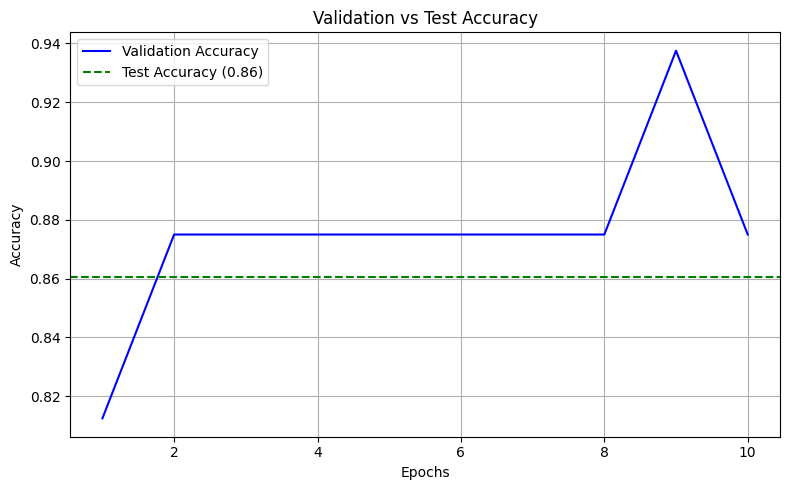

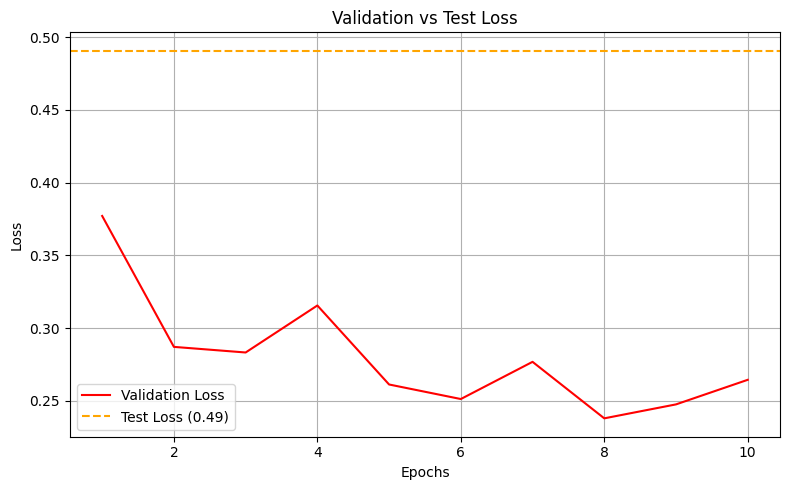

In [ ]:
results = model_mobile.evaluate(test_generator, verbose=1)
print("Evaluation Results:", results)
print("Metrics Names:", model_cnn.metrics_names)


test_loss = results[0]
test_accuracy = results[1]
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1, len(val_accuracy) + 1)

#Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, val_accuracy, 'b-', label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='green', linestyle='--', label=f'Test Accuracy ({test_accuracy:.2f})')
plt.title('Validation vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.axhline(y=test_loss, color='orange', linestyle='--', label=f'Test Loss ({test_loss:.2f})')
plt.title('Validation vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 320ms/step
 Accuracy: 0.8606
 F1 Score: 0.8985


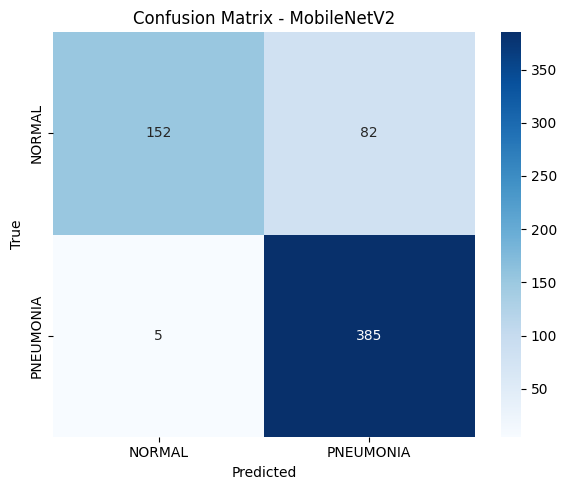


🧾 Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.97      0.65      0.78       234
   PNEUMONIA       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624



In [ ]:
pred_probs = model_mobile.predict(test_generator)
y_pred = (pred_probs > 0.5).astype(int).flatten()
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Accuracy & F1
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f" Accuracy: {accuracy:.4f}")
print(f" F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix - MobileNetV2")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Classification Report
print("\n🧾 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

## ResNet50 V2

In [ ]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)


model_resnet50v2 = Model(inputs=base_model.input, outputs=predictions)

model_resnet50v2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

model_resnet50v2.summary()


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_63"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,827,201 (90.89 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
history = model_resnet50v2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight,
    verbose=1
)
model_resnet50v2.save("chest_xray_resnet50v2.h5")
model_resnet50 = load_model("chest_xray_resnet50v2.h5")


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.6175 - loss: 0.2861 - precision: 0.8409 - recall: 0.5853 - val_accuracy: 0.8125 - val_loss: 0.3771 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 70s 856ms/step - accuracy: 0.8728 - loss: 0.1215 - precision: 0.9512 - recall: 0.8737 - val_accuracy: 0.8750 - val_loss: 0.2872 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 70s 857ms/step - accuracy: 0.8938 - loss: 0.0943 - precision: 0.9670 - recall: 0.8868 - val_accuracy: 0.8750 - val_loss: 0.2833 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 72s 877ms/step - accuracy: 0.9175 - loss: 0.0767 - precision: 0.9762 - recall: 0.9130 - val_accuracy: 0.8750 - val_loss: 0.3156 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 72s 878ms/step - accuracy: 0.9223 - loss: 0.0717 - precision: 0.9749 - recall: 0.9202 - val_accuracy: 0.8750 - val_loss:

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - accuracy: 0.7520 - loss: 0.6679 - precision: 0.4381 - recall: 0.6502
Evaluation Results: [0.41520607471466064, 0.8493589758872986, 0.8175965547561646, 0.9769230484962463]
Metrics Names: ['loss', 'compile_metrics']


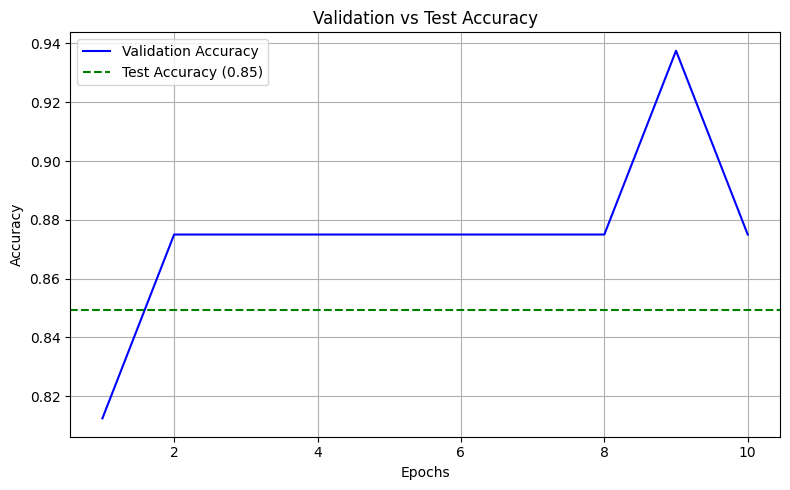

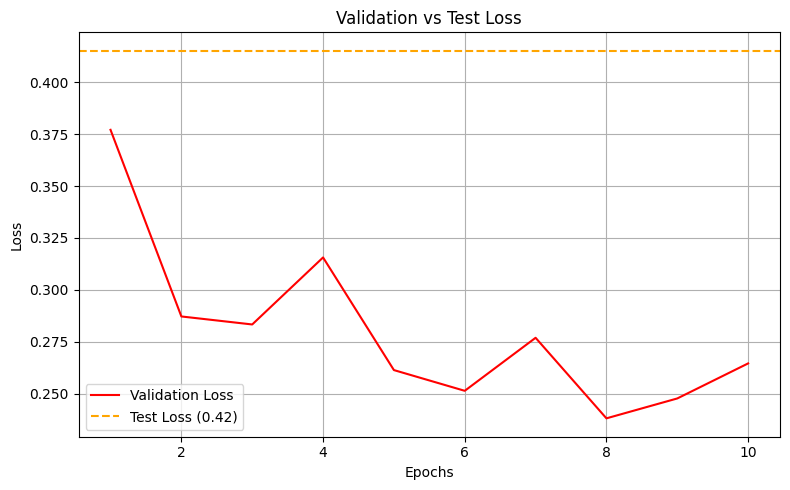

In [ ]:
results = model_resnet50.evaluate(test_generator, verbose=1)
print("Evaluation Results:", results)
print("Metrics Names:", model_cnn.metrics_names)

test_loss = results[0]
test_accuracy = results[1]
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1, len(val_accuracy) + 1)

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, val_accuracy, 'b-', label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='green', linestyle='--', label=f'Test Accuracy ({test_accuracy:.2f})')
plt.title('Validation vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.axhline(y=test_loss, color='orange', linestyle='--', label=f'Test Loss ({test_loss:.2f})')
plt.title('Validation vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 361ms/step
 Accuracy: 0.8494
 F1 Score: 0.8902


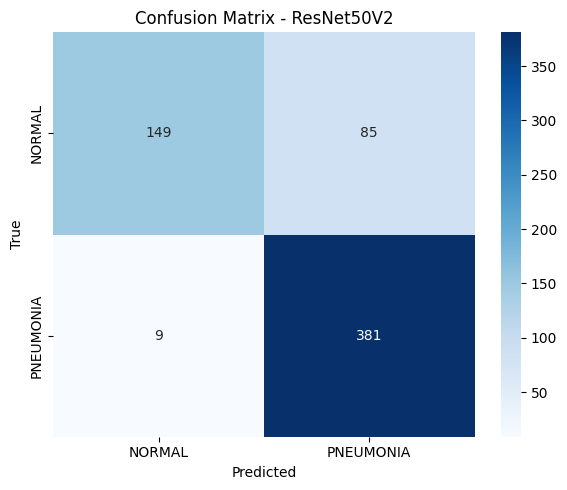


🧾 Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.94      0.64      0.76       234
   PNEUMONIA       0.82      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.86      0.85      0.84       624



In [ ]:
pred_probs = model_resnet50.predict(test_generator)
y_pred = (pred_probs > 0.5).astype(int).flatten()
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Accuracy & F1 Score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f" Accuracy: {accuracy:.4f}")
print(f" F1 Score: {f1:.4f}")

# Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix - ResNet50V2")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Classification Report
print("\n🧾 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

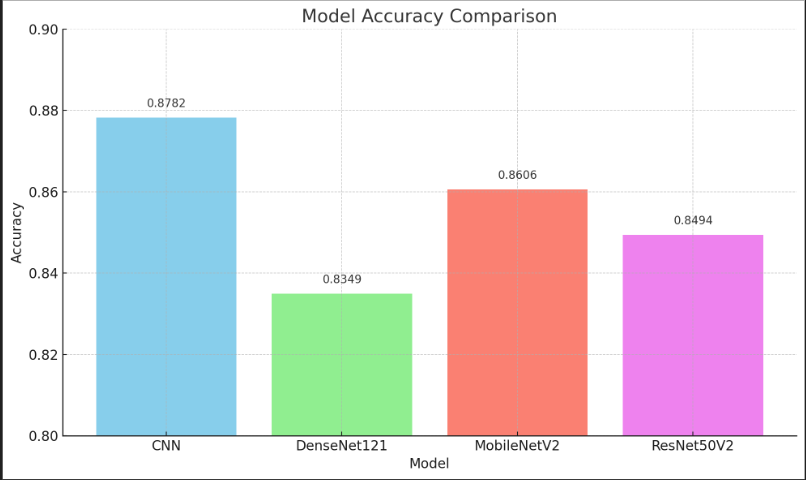

In [4]:
from IPython.display import Image
Image('/content/accuracy.PNG')

CNN achieved the highest accuracy (87.82%), making it the most effective model among those compared.


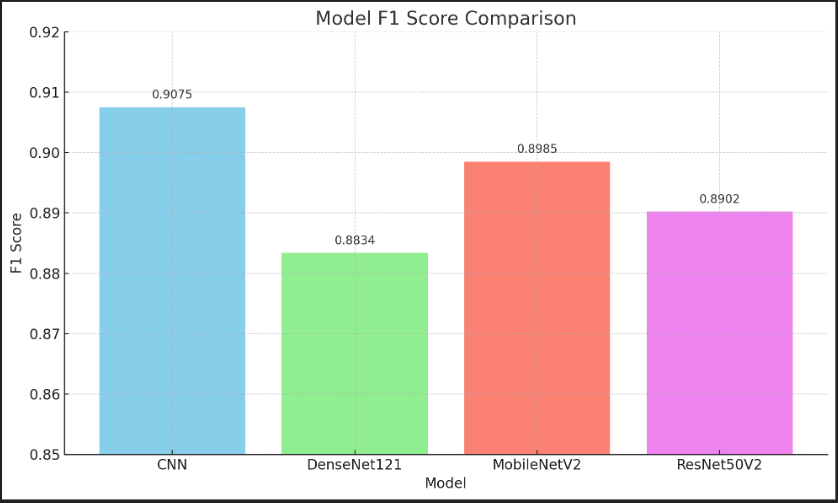

In [5]:
from IPython.display import Image
Image('/content/f1 score.PNG')

CNN again leads with the highest F1 Score (0.9075), indicating strong overall classification performance in terms of precision and recall.


## **Challenges Faced**

***Data imbalance*** – Some classes may dominate the dataset.

***Lack of Annotation Specificity:*** The dataset only had binary labels (Normal vs Pneumonia) without indicating the pneumonia type (bacterial or viral), limiting clinical interpretability.

***Lack of explainability*** – Hard to understand how decisions are made.

 ## Final Recommendation 
 ***Highest Accuracy:*** 87.82% — ensures the model correctly identifies a majority of cases, reducing misclassification.

***Highest F1 Score:*** 90.75% — demonstrates a strong balance between precision (avoiding false positives) and recall (capturing actual cases).

***Balanced Performance:*** Indicates the model is both sensitive and specific, crucial in a healthcare setting.

***Early Detection:*** Can assist doctors in identifying disease patterns or anomalies faster and more reliably.

***Decision Support:*** Helps healthcare providers make informed decisions, triage patients efficiently, and reduce diagnostic delays during overwhelming outbreaks.